In [ ]:
# Install the libraries
!pip install pandas numpy matplotlib tensorflow tqdm

In [1]:
import os
import random
import pandas as pd
import numpy as np
import pathlib
from glob import glob
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Prepare the Dataset

In [2]:
os.listdir("../dataset")

['.ipynb_checkpoints', 'COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

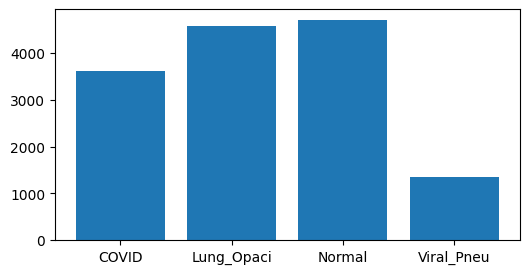

In [3]:
all_images_folder = glob("../dataset/*")
data = {name.split("\\")[-1]: len(glob(name + "/*")) for name in all_images_folder}

fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.bar(np.arange(len(data.keys())), data.values())
ax.set_xticks(np.arange(len(data.keys())))
_ = ax.set_xticklabels([key[:10] for key in data.keys()])

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 32
img_height = 180
img_width = 180

In [5]:
dataset_dir = "../dataset"

train_ds = image_dataset_from_directory(dataset_dir, 
                                       validation_split=0.2,
                                       subset="training",
                                       seed=123,
                                       batch_size=batch_size,
                                       image_size=(img_height, img_width)
                                       )

Found 14244 files belonging to 4 classes.
Using 11396 files for training.


In [6]:
val_ds = image_dataset_from_directory(dataset_dir, 
                                       validation_split=0.2,
                                       subset="validation",
                                       seed=123,
                                       batch_size=batch_size,
                                       image_size=(img_height, img_width)
                                       )

Found 14244 files belonging to 4 classes.
Using 2848 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']


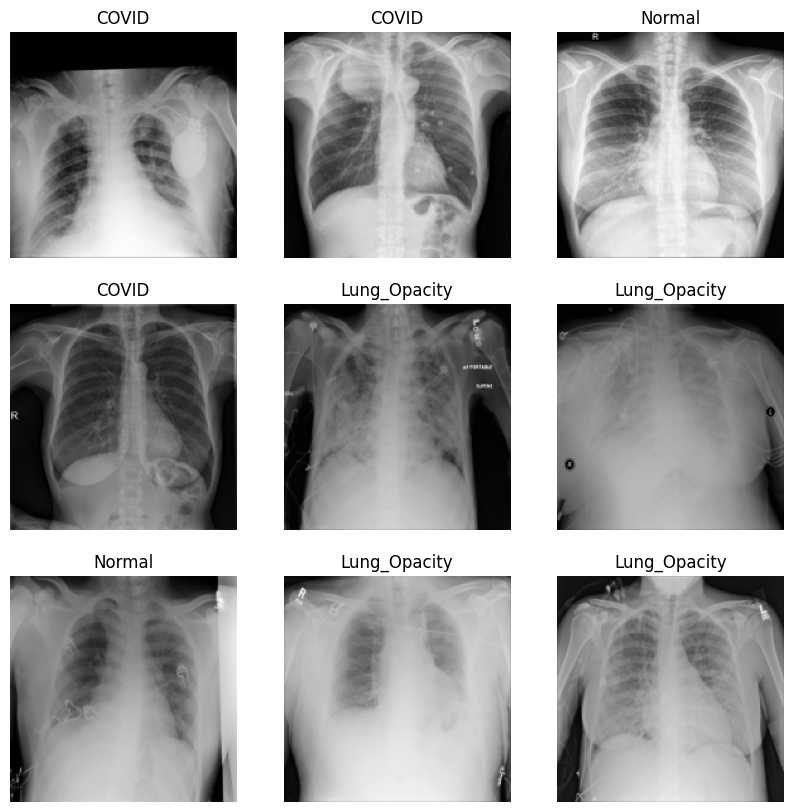

In [8]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Augmentation

In [9]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
    layers.RandomTranslation(0.05, 0.05)
])

In [10]:
image, label = next(iter(train_ds))

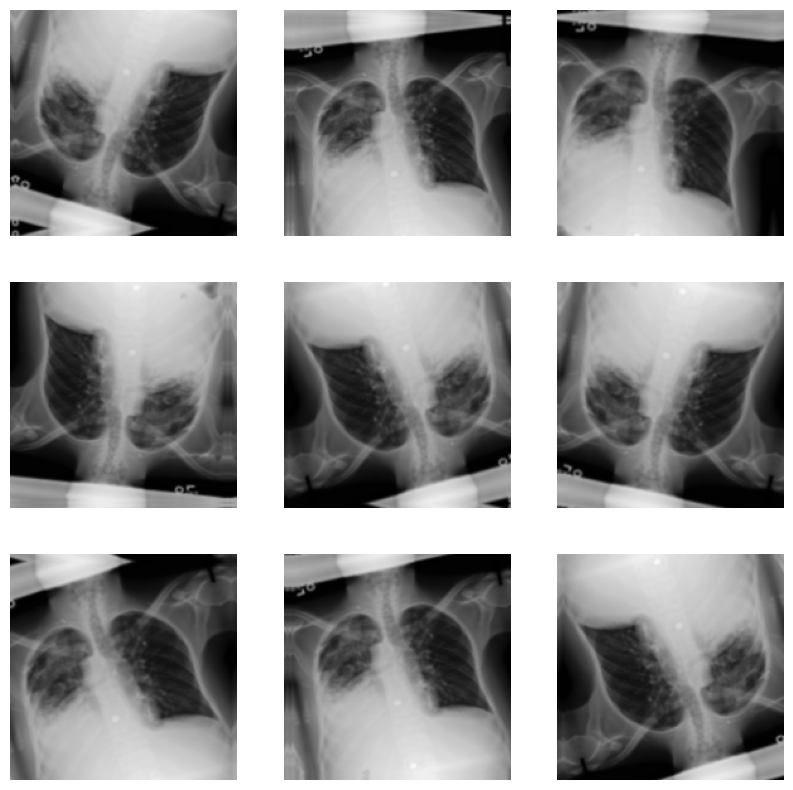

In [11]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0] / 255)
  plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [9]:
from tensorflow.keras import layers

normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.92909175


## Create a Base Model for learning

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Rescaling, Conv2D, Dense, Flatten, MaxPooling2D, Dropout, Input
from tensorflow.keras.models import Sequential

In [16]:
shape = (img_height, img_width, 3)

base_model = VGG16(
    input_shape=shape,
    include_top=False,
    weights="imagenet"
)

In [17]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#Freeze the model layer
for layer in base_model.layers:
    layer.trainable = False

In [21]:
num_classes = len(class_names)

model = Sequential([
    Input(shape),
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation,
    base_model,
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])

In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 5, 5, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,353,732 (62.38 MB)

 Trainable params: 1,639,044 (6.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
for var in model.trainable_variables:
    print(var)

<KerasVariable shape=(12800, 128), dtype=float32, path=sequential_2/dense_2/kernel>
<KerasVariable shape=(128,), dtype=float32, path=sequential_2/dense_2/bias>
<KerasVariable shape=(128, 4), dtype=float32, path=sequential_2/dense_3/kernel>
<KerasVariable shape=(4,), dtype=float32, path=sequential_2/dense_3/bias>


In [24]:
for layer in model.layers:
    print(layer)

<Rescaling name=rescaling_2, built=True>
<Sequential name=sequential, built=True>
<Functional name=vgg16, built=True>
<Dropout name=dropout_1, built=True>
<Flatten name=flatten_1, built=True>
<Dense name=dense_2, built=True>
<Dense name=dense_3, built=True>


In [28]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
print("Compiling the model ...")
model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])
print("Sucess!")

Compiling the model ...
Sucess!


In [29]:
print(f"Model output shape : {model.output_shape[1]}")

Model output shape : 4


In [30]:
#train the model
initial_epochs = 5

model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Epoch 1/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 879s 2s/step - accuracy: 0.6168 - loss: 1.0340 - val_accuracy: 0.7447 - val_loss: 0.6213
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 891s 2s/step - accuracy: 0.7700 - loss: 0.5723 - val_accuracy: 0.7665 - val_loss: 0.6047
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 922s 3s/step - accuracy: 0.7953 - loss: 0.5180 - val_accuracy: 0.8385 - val_loss: 0.4265
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 956s 3s/step - accuracy: 0.8141 - loss: 0.4668 - val_accuracy: 0.7865 - val_loss: 0.5443
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 894s 3s/step - accuracy: 0.8203 - loss: 0.4534 - val_accuracy: 0.8223 - val_loss: 0.4599


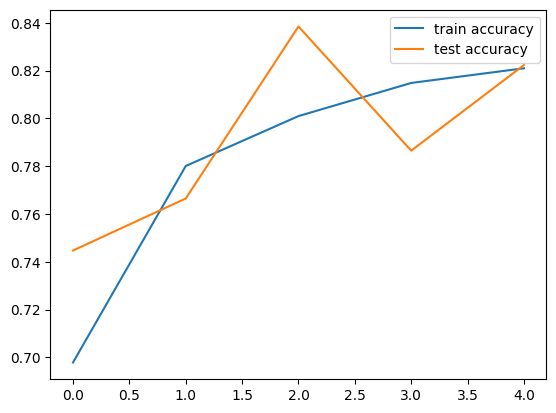

In [31]:
plt.plot(model.history.history['accuracy'], label='train accuracy')
plt.plot(model.history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

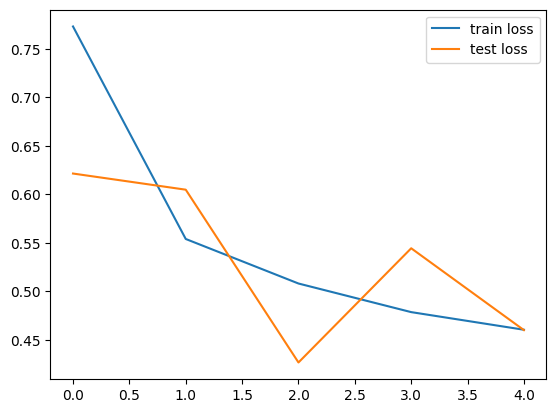

In [32]:
plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [34]:
#save the model
model.save(filepath="vgg16_tl.keras")

In [11]:
test_ds = next(iter(val_ds))

In [ ]:
predictions = model.predict(test_ds[0])
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [9]:
model_path = "vgg16_tl.keras"

model1 = tf.keras.models.load_model(model_path)

In [12]:
predictions = model1.predict(test_ds[0])
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
This image most likely belongs to COVID with a 99.73 percent confidence.


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

In [14]:
# Proceed with the predictions and printing results as shown above
y_predicted = []
y_actual = []

for ds in tqdm(val_ds):
    images, labels = ds

    # Make predictions
    predictions = model1.predict(images)

    # Convert predictions to class indices
    y_pred = np.array([np.argmax(score) for score in predictions])
    y_true = np.array(labels)

    # Print predicted and true class names for each image
    for pred, true in zip(y_pred, y_true):
        y_predicted.append(pred)
        y_actual.append(true)
        # print(f"Predicted: {class_names[pred]}, True: {class_names[true]}")

  0%|          | 0/89 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [15]:
y_predicted = np.asarray(y_predicted)
y_actual = np.asarray(y_actual)

In [16]:
report = classification_report(y_predicted, y_actual, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.90      0.79       568
           1       0.90      0.77      0.83      1071
           2       0.85      0.80      0.82      1000
           3       0.78      0.98      0.87       209

    accuracy                           0.82      2848
   macro avg       0.81      0.86      0.83      2848
weighted avg       0.84      0.82      0.82      2848



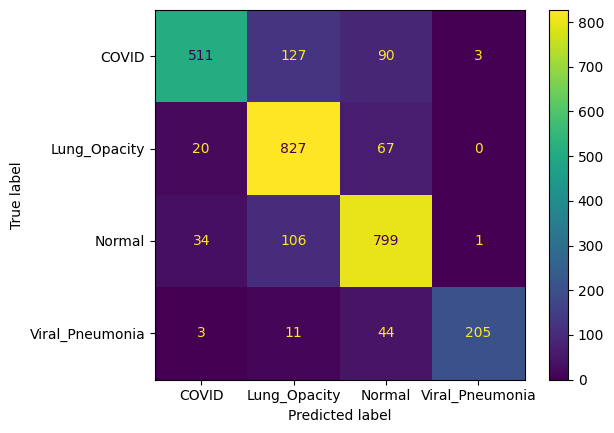

In [17]:
conf_mat = confusion_matrix(y_actual, y_predicted)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=class_names)
disp.plot()

In [25]:
print(y_predicted[:20])
print(y_actual[:20])

[2 1 2 2 1 2 0 1 2 0 2 0 0 2 3 1 1 2 1 1]
[2 1 2 0 1 2 0 1 2 2 2 2 0 2 3 1 1 0 1 0]


In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

In [27]:
# Binarize the output
classes = np.unique(y_actual)
y_actual_bin = label_binarize(y_actual, classes=classes)
y_predicted_bin = label_binarize(y_predicted, classes=classes)
n_classes = y_actual_bin.shape[1]

In [30]:
classes

array([0, 1, 2, 3])

In [31]:
y_actual_bin

array([[0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]])

In [33]:
n_classes

4

In [28]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_bin[:, i], y_predicted_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_bin.ravel(), y_predicted_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

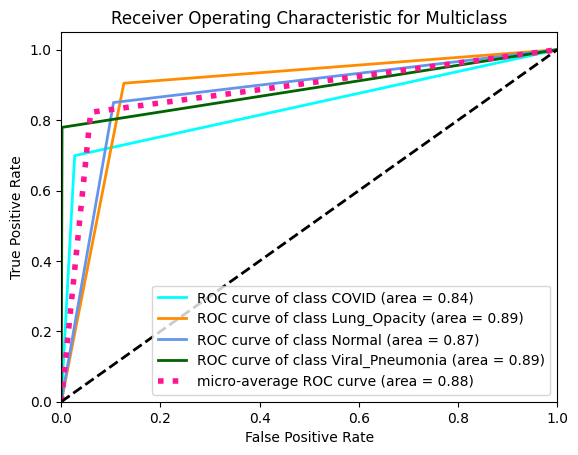

In [37]:
# Plot all ROC curves
plt.figure()

colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()

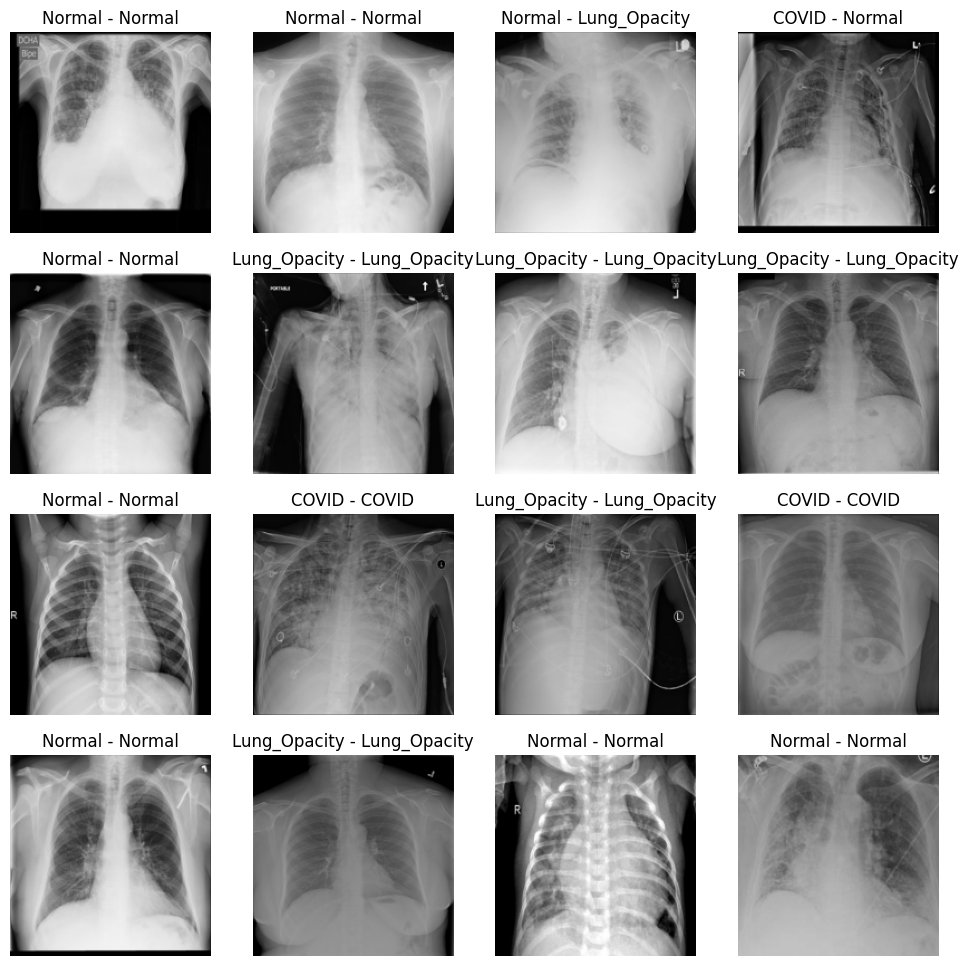

In [68]:
test_images = test_ds[0]

plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.title(class_names[y_pred[i]] +  " - " + class_names[y_true[i]])
    plt.axis("off")

In [44]:
predictions = model1.predict(test_ds[0])
y_pred = np.array([np.argmax(score) for score in predictions])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [45]:
for pred in y_pred:
    disease = class_names[pred]
    print("Predicted disease: ", disease)

Predicted disease:  COVID
Predicted disease:  Normal
Predicted disease:  Lung_Opacity
Predicted disease:  Lung_Opacity
Predicted disease:  Lung_Opacity
Predicted disease:  Lung_Opacity
Predicted disease:  Lung_Opacity
Predicted disease:  COVID
Predicted disease:  Normal
Predicted disease:  Lung_Opacity
Predicted disease:  Lung_Opacity
Predicted disease:  COVID
Predicted disease:  Lung_Opacity
Predicted disease:  Normal
Predicted disease:  Normal
Predicted disease:  Lung_Opacity
Predicted disease:  Lung_Opacity
Predicted disease:  Normal
Predicted disease:  Normal
Predicted disease:  Lung_Opacity
Predicted disease:  Normal
Predicted disease:  Normal
Predicted disease:  Lung_Opacity
Predicted disease:  COVID
Predicted disease:  COVID
Predicted disease:  Lung_Opacity
Predicted disease:  COVID
Predicted disease:  COVID
Predicted disease:  Lung_Opacity
Predicted disease:  Lung_Opacity
Predicted disease:  COVID
Predicted disease:  COVID
